# Inverse Problems : The Accelerated Bayesian Approach

This numerical tour follows a Bayesian approach in Inverse Problems. For this tour we will demonstrate the methodology to perform Bayesian computation for an image deconvolution problem, for this example we will use a convex handcrafted prior for reconstruction and uncertainty quantification. As sampling algorithm we will use an accelerated Markov Chain Monte Carlo algorithm called [SK-ROCK](https://pure.hw.ac.uk/ws/portalfiles/portal/41830170/19m1283719.pdf).

In [1]:
import math
import numpy as np
import time as time
from tqdm.auto import tqdm
from PIL import Image

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

from functions import *
import large_scale_UQ as luq

# Check if there's a GPU available and run on GPU, otherwise run on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


For many problems in imaging, we are interested in recovering an image of interest, $x \in \mathbb{R}^d$, from a set of measurements $y \in \mathbb{R}^n$.

We consider measurement models of the form 

$$y = Ax + w,$$ 

where $A \in \mathbb{R}^{n \times d}$ is a linear operator and $w \sim N(0, \sigma^2 I_d)$ is a noise term.  Here, we study the case where both $A$ and $\sigma^2 >0$ are known. The measurement model defines a likelihood function $p(y|x)\propto e^{-f_{y}(x)}$, where $f_{y}$ (negative log-likelihood) is proper, lower semi-continuous, convex and gradient $L_{y}$-Lipschitz.

The recovery of $x$ from $y$ is often ill posed or ill conditioned, so we regularize with prior information. The regularization will take the form of a prior distribution $p(x|\theta)\propto e^{-\theta g(x)}$, where $g: \mathbb{R}^{d} → \mathbb{R}$ is a proper, lower semi-continuous and convex function, but potentially not smooth. The parameter $\theta$ controls the amount of regularity enforced by the prior and requires careful setting. Having the likelihood and prior model, Bayes Theorem permits us to define the posterior distribution as follows

$$p(x|y;\theta) = \dfrac{p(y|x)p(x|\theta)}{p(y|\theta)} \propto e^{-f_{y}(x)-\theta g(x)},$$
where the marginal likelihood $p(y|\theta)$ is defined by
$$ p(y|\theta) = \int_{\mathbb{R}^d}e^{-f_{y}(\tilde{x})-\theta g(\tilde{x})}d\tilde{x}.$$

In this tour, our aim is to calculate the Minimum Mean Square Error (MMSE) Bayesian estimator defined as

$$\hat{x}_{MMSE} = \argmin_{u\in\mathbb{R}^{d}}\mathbb{E}\left[||x-u||^{2}|y\right]= \mathbb{E}\left[x|y\right] = \int_{\mathbb{R}^{d}}\tilde{x}p(\tilde{x}|y)d\tilde{x}.$$

Moreover, as a toy illustration of an uncertainty visualisation analysis, we also calculate the posterior variance for each image pixel $x_{i}$, for $i = 1,\ldots,d$, defined as

$$\operatorname{Var}\left[x_i|y\right] = \mathbb{E}\left[x_i^{2}|y\right] - \mathbb{E}\left[x_i|y\right]^{2},$$

where

$$\mathbb{E}\left[x_i^{2}|y\right]=\int_{\mathbb{R}^{d}}\tilde{x_i}^{2}p(\tilde{x_i}|y)d\tilde{x_i}.$$

## Loading and Blurring the Image
Deconvolution methods consist in removing a blur from a degraded measurement. First we load the image to be used for the rest of the notebook.

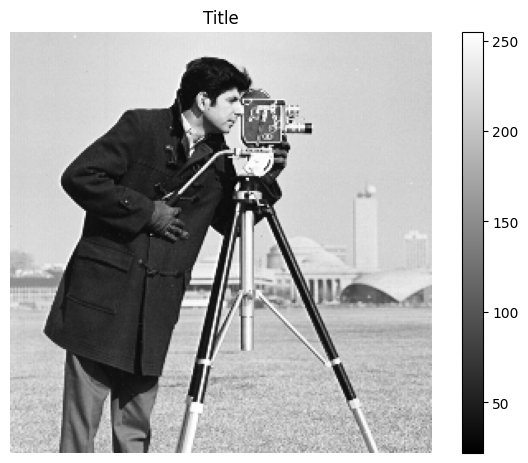

In [2]:
# Load grayscale image
im = np.array(Image.open("cman.png")) 
plot_im(im)

# Convert to torch tensor
x = torch.Tensor(im/255.).to(device)

Define the convolution kernel A. Here a 5x5 uniform blur is used. The `blur_operators()` function implements the forward operations $A$ and $A^T$ respectively (computed by calling A(x) and AT(x)) as well as the spectral norm $||AA^T||_{2}^{2}$.

The calculation of $||AA^T||_{2}^{2}$ is necessary since it appears in the Lipschitz constant of the model and plays a role for the stepsize of the presented algorithms.

In [3]:
kernel_len = [5,5]
size = [im.shape[0],im.shape[1]]
type_blur = "uniform"
A, AT, AAT_norm = blur_operators(kernel_len, size, type_blur, var = None)

Apply the filter and add some noise to obtain the measurements $y = Ax + w$ and achieve a blurred signal-to-noise ratio (BSNR) of 40dB.

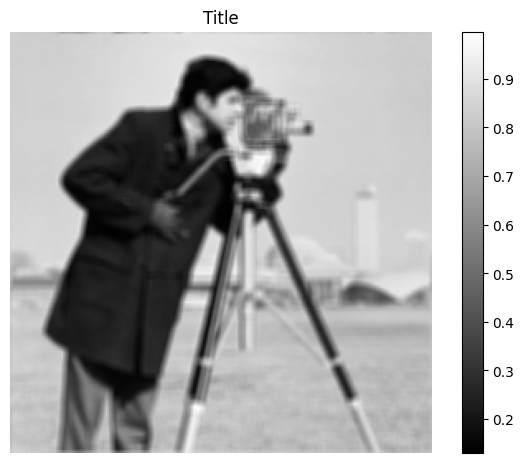

In [4]:
y0 = A(x)

BSNRdb = 40
sigma = torch.linalg.matrix_norm(A(x)-torch.mean(A(x)), ord='fro')/math.sqrt(torch.numel(x)*10**(BSNRdb/10))

y = y0 + sigma * torch.randn_like(x)
plot_im(y)

# Markov Chain Monte Carlo (MCMC) methods in imaging inverse problems

It is clear that the calculation of the integrals defined above is a computationally infeasible task in high dimensions. Stochastic simulation algorithms, namely Markov Chain Monte Carlo (MCMC) algorithms, estimate these integrals by sampling. For example, if we could get i.i.d. samples $\{X_{i}\}_{i=1}^{N}$ from $p(x|y;\theta)$ the posterior mean, $\hat{x}_{MMSE}$, is approximated by



$$\hat{x}_{MMSE}\approx \frac{1}{N}\sum_{i=1}^{N}X_{i},$$

with the Monte Carlo approximation error vanishing as $N → ∞$.

The question that arises here is how can we sample from the posterior? Under a smooth prior, one common approach is to solve the overdamped Langevin stochastic differential equation (SDE)

$$
dX_{t} = \nabla \log p(X_{t}|y,\theta)dt + \sqrt{2}W_{t}=
\nabla \log p(y|X_{t};\theta)dt + \nabla \log p(X_{t}|\theta)dt+ \sqrt{2}W_{t}
$$

where $(W_{t})_{t\geq0}$ is a d-dimensional Brownian motion. Under mild conditions, the above SDE has a unique strong solution $(X_{t})_{t>0}$ that admits the posterior of interest $p(x|y;\theta)$ as unique stationary density.

Solving the SDE above for higher dimensional problems is inherently difficult. A natural choice is to use an Euler Maruyama discretization approach such as [MYULA](https://epubs.siam.org/doi/10.1137/16M1108340 "Read more about MYULA") (see also [MYULA notebook](Link to be added)).

However, when $p(x|y;\theta)$ arises as the posterior distribution from an imaging inverse problem, then the problem is typically ill-conditioned and this results in the Lipschitz constant $L$ of $\nabla \log\pi$ being very large. This is an issue when using MYULA since the scheme has a stability barrier of $2/L$ which leads to a small stepsize.

We can improve on the Euler scheme by using a Runge-Kutta stochastic integration scheme [SK-ROCK](https://epubs.siam.org/doi/pdf/10.1137/19M1283719 "Read more about SK-ROCK") which uses several gradient evaluations per iteration of the scheme to obtain a scheme with significantly improved convergence properties. The scheme we use here is the SK-ROCK method which uses Chebshev polynomials of order $s$ to take larger time steps than the stability barrier for MYULA.
Unlike MYULA that uses a single evaluation of $\nabla \log p(x|y;\theta)$ per iteration, SKROCK evaluates $s\in \mathbb{N}^*$ times the $\nabla \log p(x|y;\theta)$ at carefully chosen extrapolated points determined by Chebyshev polynomials $T_s$ of the first kind defined as follows.

$$
T_{k+1} = 2xT_k(x) -T_{k-1}(x) \text{ with } T_0(x) = x, \text{ and } T_1(x) = 1.
$$

Given $X_0\in \mathbb{R}^d$, $\lambda >0$, $s\in \mathbb{N}^*$, the Markov chain $\left(X_k\right)_{n\in\mathbb{N}}$ generated with [SK-ROCK](https://epubs.siam.org/doi/pdf/10.1137/19M1283719 "Read more about SK-ROCK") is ergodic with stationary distribution close to $p(x|y,\theta)$. See [details](#sk-rock-algorithm) of the SKROCK algorithm further down in this notebook.



## Likelihood

Since, we assumed Gaussian noise, the likelihood $p(y|x)$ is Gaussian given by the forward model $y = Ax + w$. Here we keep track of the negative log-likelihood as termed data fidelity term  
$f_y: x\mapsto \dfrac{1}{2\sigma^2}||y-A(x)||^{2}_{2}.$

In [6]:
f = lambda x : (torch.linalg.matrix_norm(y-A(x), ord='fro')**2.0)/(2.0*sigma**2)

Define the gradient of the negative log-likelihood $f_{y}$.

In [7]:
gradf = lambda x: AT(A(x)-y)/sigma**2

The Lipschitz constant $L_{y}$ related to the specific likelihood's gradient (useful for the stepsize choice) is $\dfrac{||AA^T||_2}{\sigma^2}$. We calculated $||AA^T||_2$ earlier.

In [8]:
L_y = AAT_norm/(sigma**2)

## Define a prior

Regularisation terms which are traditionally used for inverse problems are typically nonsmooth as this promotes solutions with some desired properties such as sparsity or edge preservation. The posterior $p(x|y;\theta)$ is then also nonsmooth because the prior $p(x|\theta)$ is not smooth.

In this context, the gradient $x\mapsto\nabla_x\log p(x|\theta)$ is not available and we need an approximation of $\tilde{g}(x)=\theta g(x)=-\log p(x|\theta)$. To smooth $\tilde{g}$, we consider its Moreau-Yosida (MY) envelope defined as

$$\tilde{g}^{\lambda}(x)=\min_{u\in\mathbb{R}^{d}}\{\tilde{g}(u)+(2\lambda)^{-1}||u-x||^{2}\}$$

The Moreau Yosida envelope $\tilde{g}^{\lambda}$ is gradient Lipschitz with the Lipschitz constant $L_{\tilde{g}^{\lambda}}= \dfrac{1}{\lambda}$. The gradient  of $\tilde{g}^\lambda$ is given by

$$\nabla \tilde{g}^{\lambda}(x)=\lambda^{-1}(x-\mathrm{prox}_{\tilde{g}}^{\lambda}(x)),$$

where 

$$\mathrm{prox}_{\tilde{g}}^{\lambda}(x)=\mathrm{prox}_{g}^{\theta\lambda}(x)=\arg\min_{u\in\mathbb{R}^{d}}\left\{\theta g(u)+\dfrac{1}{2\lambda}||u-x||^{2}\right\}$$
is the proximal operator of $g$. Therefore instead of approximating the overdamped Langevin for $p(x|y)$ we consider 
$$
dX_t = \nabla f_y(x)dt + \lambda^{-1}(x-\mathrm{prox}_{g}^{\theta\lambda}(x))dt+ \sqrt{2}W_{t}.
$$


In this tour, we will consider a total variation (TV) prior given as follows

$$p(x) \propto e^{- \theta ||x|| _{TV}}\,\,,$$

and so $g(x)=||x|| _{TV}$ where $||x|| _{TV}=\sum_{i,j}^{}\sqrt{|x_{i+1,j}-x_{i,j}|^2+|x_{i,j+1}-x_{i,j}|^2}$. The intuition behind the TV norm is that it promotes piecewise linear solutions. The function `g_fun_theta()` calculates the $\theta||\cdot|| _{TV}$.

Although we assumed the parameter $\theta$ is known in this tour, we can calibrate $\theta$ online by implementing the [stochastic approximation proximal gradient algorithm (SAPG)](https://epubs.siam.org/doi/pdf/10.1137/20M1339829 "Read more about SAPG").

In [9]:
theta = 0.047*255.
g_fun_theta = lambda x : theta*tv(Grad_Image(x))                    

In [10]:
# Define the wavelet dict
wavs_list = ['db8'] # ["db1", "db4"] 
levels = 4
# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(y))) * theta
h.gamma = gamma
h.beta = 1.0

g_fun_theta = lambda x : h._fun_coeffs(h.dir_op(x))



The function `proxg()` below calculates the proximity operator when $g(x)=||\cdot||_{TV}$ which is not a smooth function as

$$\operatorname{prox}_{g}^{\lambda}(x)=\argmin_{u\in\mathbb{R}^{d}}\{||u||_{TV}+(2\lambda)^{-1}||u-x||^{2}\}\,\,.$$

The function `gradg()` calculates $$\theta\nabla g^{\lambda}(x)=\lambda^{-1}(x-\mathrm{prox}_{g}^{\theta\lambda}(x))\,\,.$$

The parameter $\lambda$ is chosen to be equal to $\alpha L^{-1}_{y}$, where $\alpha \in (0,1)$. To compute the proximal operator $\mathrm{prox}_{g}^{\theta\lambda}$ we used $25$ iterations with smoothing parameter $\theta\lambda$.

In [11]:
lambda_prox = 1/L_y
lambd_frac = 0.99
lambd = lambda_prox*lambd_frac

proxg = lambda x: chambolle_prox_TV(x,{'lambda' : theta*lambd, 'MaxIter' : 25})
gradg = lambda x: (x -proxg(x))/lambd 

In [12]:
proxg = lambda x: h.adj_op(h.prox(h.dir_op(torch.clone(x)), lambd))
gradg = lambda x: (x -proxg(x))/lambd 

## Define the log-posterior and its gradient
The $\log$ posterior is given by 
$$\log p^{\lambda}(x|y;\theta) = f(x) - \theta g^{\lambda}(x)$$
and its gradient $x \mapsto \nabla_x\log p^{\lambda}(x|y;\theta)$ is defined as
$$\nabla_x\log p^{\lambda}(x|y;\theta) = -\nabla_xf(x) - \theta \nabla_x g^{\lambda}(x)$$

In [13]:
log_pi = lambda z:  (- f(z) - g_fun_theta(z))
grad_f_g = lambda x: gradf(x) + gradg(x)

## SK-ROCK Algorithm

As we aforementioned our aim is to calculate the posterior mean by SK-ROCK as
$$\hat{x}_{MMSE} = \mathbb{E}(x|y) = \int_{\mathbb{R}^{d}}\tilde{x}p(\tilde{x}|y;\theta)d\tilde{x}\approx \dfrac{1}{N}\sum_{i=1}^{N}X_{i}$$

and the posterior variance for each image pixel $x_{i}$, for $i = 1,\ldots,d$, as

$$\operatorname{Var}(x_i|y) = \mathbb{E}(x_i^{2}|y) - (\mathbb{E}(x_i|y))^{2} \approx \dfrac{1}{N}\sum_{i=1}^{N}X_{i}^2 - \left(\dfrac{1}{N}\sum_{i=1}^{N}X_{i}\right)^2\,\,.$$

Additionally:

1) We are keeping track of the reconstruction quality of the MMSE estimate by calculating the Normalized Mean Square Error (NRMSE), the Peak-Signal-to-Noise Ratio (PSNR) and the Structural Similarity Index Measure (SSIM) w.r.t. the ground truth image.

2) We are keeping track of the evaluations of the log-posterior at the samples.

### SK-ROCK Kernel Updates

The SK-ROCK kernel updates are presented below:

**Compute** 

$$\omega_0 = 1 + \dfrac{\eta}{s^2} \hspace{1cm} \omega_1 = \dfrac{T_s}{T'_s} \hspace{1cm} \mu_1 = \dfrac{\omega_1}{\omega_0} \hspace{1cm} \nu_1 = \dfrac{s\omega_1}{2} \hspace{1cm} k_1 = \dfrac{s\omega_1}{\omega_0}$$

**Choose** $\delta \in (0, \delta^{max}_s]$, where $\delta^{max}_s = \ell_s/L$ with 

$$\ell_s = (s-0.5)^2(2-4/3\eta)-1.5$$ 

and 

$$L=L_{y} + L_{\tilde{g}^{\lambda}}$$

where $L_{y}$ being the Lipschitz constant of $\nabla f_{y}$ and $L_{g^{\lambda}} = \frac{1}{\lambda}$ the Lipschitz constant of $\theta \nabla g^{\lambda}$. We will consider $\delta = \alpha  \delta^{max}_s$ with $\alpha=0.99$. $\alpha$ can be chosen smaller, but this would defeat the purpose of taking the largest possible time step.

**Suppose that** the current state of the chain is $X_t$. The next update is calculated as:

$$K_1 = X_t + \mu_1 \delta \nabla \log p(X_{t}+\nu_1\sqrt{2\delta}Ζ_{i+1}|y,\theta) + k_1 \sqrt{2\delta}Ζ_{i+1} \hspace{1cm} Ζ_{i+1}\sim \mathcal{N}(0,\mathbb{I}_d)$$

**Compute** $\forall j=2,\dots,10$

$$\mu_j = \dfrac{2\omega_1 T_{j-1}(\omega_0)}{T_{j}(\omega_0)} \hspace{1cm} \nu_j = \dfrac{2\omega_0 T_{j-1}(\omega_0)}{T_{j}(\omega_0)} \hspace{1cm} k_j = -\dfrac{T_{j-2}(\omega_0)}{T_{j}(\omega_0)} \hspace{1.5cm} $$

$$K_j = \mu_j \delta \nabla \log p(K_{j-1}|y,\theta) + \nu_j K_{j-1} + k_j K_{j-2}$$

Then, the **new state** will be 

$$X_{i+1} = K_s$$

In [14]:
def SKROCK_kernel(X: torch.Tensor,Lipschitz_U,nStages: int,eta: float,dt_perc,gradU):

    # SK-ROCK parameters

    # First kind Chebyshev function

    T_s = lambda s,x: np.cosh(s*np.arccosh(x))

    # First derivative Chebyshev polynomial first kind

    T_prime_s = lambda s,x: s*np.sinh(s*np.arccosh(x))/np.sqrt(x**2 -1)

    # computing SK-ROCK stepsize given a number of stages

    # and parameters needed in the algorithm

    denNStag=(2-(4/3)*eta)

    rhoSKROCK = ((nStages - 0.5)**2) * denNStag - 1.5 # stiffness ratio

    dtSKROCK = dt_perc*rhoSKROCK/Lipschitz_U # step-size

    w0=1 + eta/(nStages**2) # parameter \omega_0

    w1=T_s(nStages,w0)/T_prime_s(nStages,w0) # parameter \omega_1

    mu1 = w1/w0 # parameter \mu_1

    nu1=nStages*w1/2 # parameter \nu_1

    kappa1=nStages*(w1/w0) # parameter \kappa_1

    # Sampling the variable X (SKROCK)

    Q=math.sqrt(2*dtSKROCK)*torch.randn_like(X) # diffusion term

    # SKROCK

    # SKROCK first internal iteration (s=1)

    XtsMinus2 = X.clone()

    Xts= X.clone() - mu1*dtSKROCK*gradU(X + nu1*Q) + kappa1*Q

    for js in range(2,nStages+1): # s=2,...,nStages SK-ROCK internal iterations

        XprevSMinus2 = Xts.clone()

        mu=2*w1*T_s(js-1,w0)/T_s(js,w0) # parameter \mu_js

        nu=2*w0*T_s(js-1,w0)/T_s(js,w0) # parameter \nu_js

        kappa=1-nu # parameter \kappa_js

        Xts= -mu*dtSKROCK*gradU(Xts) + nu*Xts + kappa*XtsMinus2

        XtsMinus2=XprevSMinus2

    return Xts # new sample produced by the SK-ROCK algorithm


### Setup the stepsize and additional parameters

Since an MCMC algorithm needs to be implemented - as this is explained above - we will need to choose the step-size $\delta$. In order to converge, we need to take $\delta \in (0, \delta^{max}_s]$ where $\delta^{max}_s = \ell_s/L$ with 

$$\ell_s = \left(s-0.5\right)^2\left(2-\frac{4}{3}\eta\right)-1.5$$ 

and 

$$L=L_{y} + L_{g^{\lambda}}$$

where $L_{y}$ is the Lipschitz constant of $\nabla f_{y}$ and $L_{g^{\lambda}} = \frac{1}{\lambda}$ is the Lipschitz constant of $\theta\nabla g^{\lambda}$. We will consider $\delta = \alpha \delta^{max}_s$ with $\alpha=0.99$.

In [15]:
L_g= 1/lambd
L = L_y + L_g
s = 10
eta = 0.05
dt_perc = 0.99

### Algorithm choices and initializations

Choose the number of sampling iterations, here it is $10^{3}$. This corresponds to a computational budget of $10^{4}$ if we would run ULA, as for the choice of $s=10$ stages $10$ gradient evaluations are used to compute the next step in the sampling algorithm. This algorithm significantly accelerates the sampling process compared with ULA, and so less iterations will be needed for convergence. In practice, you might want to use 10k-20k iterations. A burn-in period of $5\%$ is also included. The Markov chain is initialized with the observation $y$. In total, for this example, we would like to save a trace of 500 samples, so we set the thinning variable accordingly. Sidenote: If you want to compare ULA and SKROCK, you will need to consider thinning the chain generated by ULA by $s$.

In [16]:
maxit = 1000
burnin = np.int64(maxit*0.3)
X = y.clone()
n_samples = 500
MC_X = []
thinned_trace_counter = 0
thinning_step = np.int64(maxit/n_samples)

### Quality metrics
We are keeping track of the reconstruction quality of the MMSE estimate via the NRMSE, PSNR, SSIM w.r.t. to the ground truth image and the log-posterior on the fly.

In [17]:
nrmse_values = []
psnr_values = []
ssim_values = []
log_pi_trace = []

### The Algorithm in Practice

1. For each iteration is calculated using the SK-ROCK kernel.

2. After the burning-period we start calculating the posterior sample mean and variance on the fly by updating them in each iteration. We are using the `welford` class for this. The `update()` function of the class updates the sample mean and variance in each iteration.

3. We also keeping track of the samples in the Fourier domain calculating respective the posterior mean and variance on the fly in the Fourier domain. This can be accomplished by just giving as input in the `welford()` class the absolute value fo the FT of the samples.


In [18]:
#sampling using skrock
start_time = time.time()

for i_x in tqdm(range(maxit+burnin)):

    # Update X
    X = SKROCK_kernel(X, L, s, eta, dt_perc, grad_f_g)

    # when the burnin period has ended, start collecting statistics
    if i_x == burnin:
        # Initialise recording of sample summary statistics
        post_meanvar = welford(X)
        var_C = welford(torch.real(torch.fft.fft2(X)))
        absfouriercoeff = welford(torch.fft.fft2(X).abs())
        count = 0
        
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())  

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        nrmse_values.append(NRMSE(x, current_mean))
        psnr_values.append(PSNR(x, current_mean))
        ssim_values.append(SSIM(x, current_mean))
        log_pi_trace.append(log_pi(X).cpu().numpy())
        
        # collect thinned trace
        if count == thinning_step-1:
            var_C.update(torch.real(torch.fft.fft2(X)))
            MC_X.append(X.detach().cpu().numpy())
            count = 0
        else:
            count += 1
            
MC_X = np.stack(MC_X)
var_mat = var_C.get_var().detach().cpu().numpy().reshape(-1,1)
end_time = time.time()
elapsed = end_time - start_time       

  0%|          | 0/1300 [00:00<?, ?it/s]

Evaluate metrics of noisy image $y$.


In [19]:
print(f"Initial NRMSE: {NRMSE(x,y):.4f}")
print(f"Initial PSNR: {PSNR(x,y):.2f} dB")
print(f"Initial SSIM: {SSIM(x,y):.4f}")

Initial NRMSE: 0.1174
Initial PSNR: 21.61 dB
Initial SSIM: 0.6960


Evaluate metrics of posterior mean.


In [20]:
print(f"Result NRMSE: {NRMSE(post_meanvar.get_mean(),x):.4f}" )
print(f"Result PSNR: {PSNR(post_meanvar.get_mean(),x):.2f} dB")
print(f"Result SSIM: {SSIM(post_meanvar.get_mean(),x):.4f}")

Result NRMSE: 0.0688
Result PSNR: 26.28 dB
Result SSIM: 0.8313


# Plotting Results
We display below the ground truth and noisy and blurry image, the posterior mean (**MMSE** solution of the inverse problem), the posterior variance (which is useful for quantifying the uncertainties) and further statistics in the second row. More specifically, we display ratios of the posterior mean over the posterior standard deviation (SD, taking the root of the variance) as well as the ratio of the SD over the posterior mean in the spatial domain (so called coefficients of variation), and the mean and variance in log scale in Fourier domain. The following row shows the image quality metrics (NMRSE, PSNR, SSIM) for the cumulative mean, which tells us about the convergence of the algorithm (when the curves are completely flattened out). Last but not least, we display the trace of $\log \pi$ which gives an indication about how well the chain is mixing and whether it has reached stationarity (in which case the chain will hover around a range of values).

In [21]:
def plots(x,y,post_meanvar,post_meanvar_absfourier, nrmse_values, psnr_values, ssim_values, logPi_trace):
    
    post_mean_numpy = post_meanvar.get_mean().detach().cpu().squeeze().numpy()
    post_var_numpy = post_meanvar.get_var().detach().cpu().squeeze().numpy()
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,10))
    fig.tight_layout(pad=.01)
    
    # --- Ground truth
    plot1 = plt.figure()
    axes[0,0].imshow(x.detach().cpu().squeeze().numpy(), cmap="gray")
    axes[0,0].set_title('Ground truth image')
    axes[0,0].axis('off')
    plt.close()

    # --- Blurred
    plot1 = plt.figure()
    axes[0,1].imshow(y.detach().cpu().squeeze().numpy(), cmap="gray")
    axes[0,1].set_title('Blurred noisy image')
    axes[0,1].axis('off')
    plt.close()

    # --- MMSE
    plot1 = plt.figure()
    axes[0,2].imshow(post_mean_numpy, cmap="gray")
    axes[0,2].set_title('x - posterior mean')
    axes[0,2].axis('off')

    # --- Variance
    axes[0,3].imshow(post_var_numpy, cmap="gray")
    axes[0,3].set_title('x - posterior variance')
    axes[0,3].axis('off')
    plt.close()

    # --- MMSE / Var
    plot1 = plt.figure()
    axes[1,0].imshow(post_mean_numpy/np.sqrt(post_meanvar.get_var().detach().cpu().squeeze().numpy()), cmap="gray")
    axes[1,0].set_title('x - posterior mean/posterior SD')
    axes[1,0].axis('off')
    plt.close()

    # --- Var / MMSE
    plot1 = plt.figure()
    axes[1,1].imshow(np.sqrt(post_var_numpy)/post_mean_numpy,cmap="gray")
    axes[1,1].set_title('x - Coefs of variation')
    axes[1,1].axis('off')
    plt.close()

    # --- Mean Fourier coefs
    plot1 = plt.figure()
    axes[1,2].imshow(torch.log(post_meanvar_absfourier.get_mean()).detach().cpu().squeeze().numpy())
    axes[1,2].set_title('Mean coefs (log-scale)')
    axes[1,2].axis('off')
    plt.close()
    
    # --- Variance Fourier coefs
    plot1 = plt.figure()
    axes[1,3].imshow(torch.log(post_meanvar_absfourier.get_var()).detach().cpu().squeeze().numpy())
    axes[1,3].set_title('Var coefs (log-scale)')
    axes[1,3].axis('off')
    plt.close()
                
    # --- NRMSE ---                
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
    fig.tight_layout(pad=.01)
    
    plot1 = plt.figure()
    axes[0].plot(np.arange(len(nrmse_values))[::10], nrmse_values[::10], label =  "-- NRMSE --")
    axes[0].set_title('NRMSE of $X$ vs $x_{gr}$')
    axes[0].legend()
    plt.close()
    
    # --- PSNR ---
    plot1 = plt.figure()
    axes[1].plot(np.arange(len(psnr_values))[::10], psnr_values[::10], label =  "-- PSNR --")
    axes[1].set_title('PSNR of $X$ vs $x_{gr}$')
    axes[1].legend()
    plt.close()

    # --- SSIM ---
    plot1 = plt.figure()
    axes[2].plot(np.arange(len(ssim_values))[::10],ssim_values[::10], label =  "-- SSIM --")
    axes[2].set_title('SSIM of $X$ vs $x_{gr}$')
    axes[2].legend()
    plt.close()
                     
    # --- log pi
    plot = plt.figure(figsize = (15,10))
    
    plt.plot(np.arange(len(logPi_trace))[::10],logPi_trace[::10], label =  "- $\log \pi$ -")
    plt.legend()
    plt.show()
    plt.close()


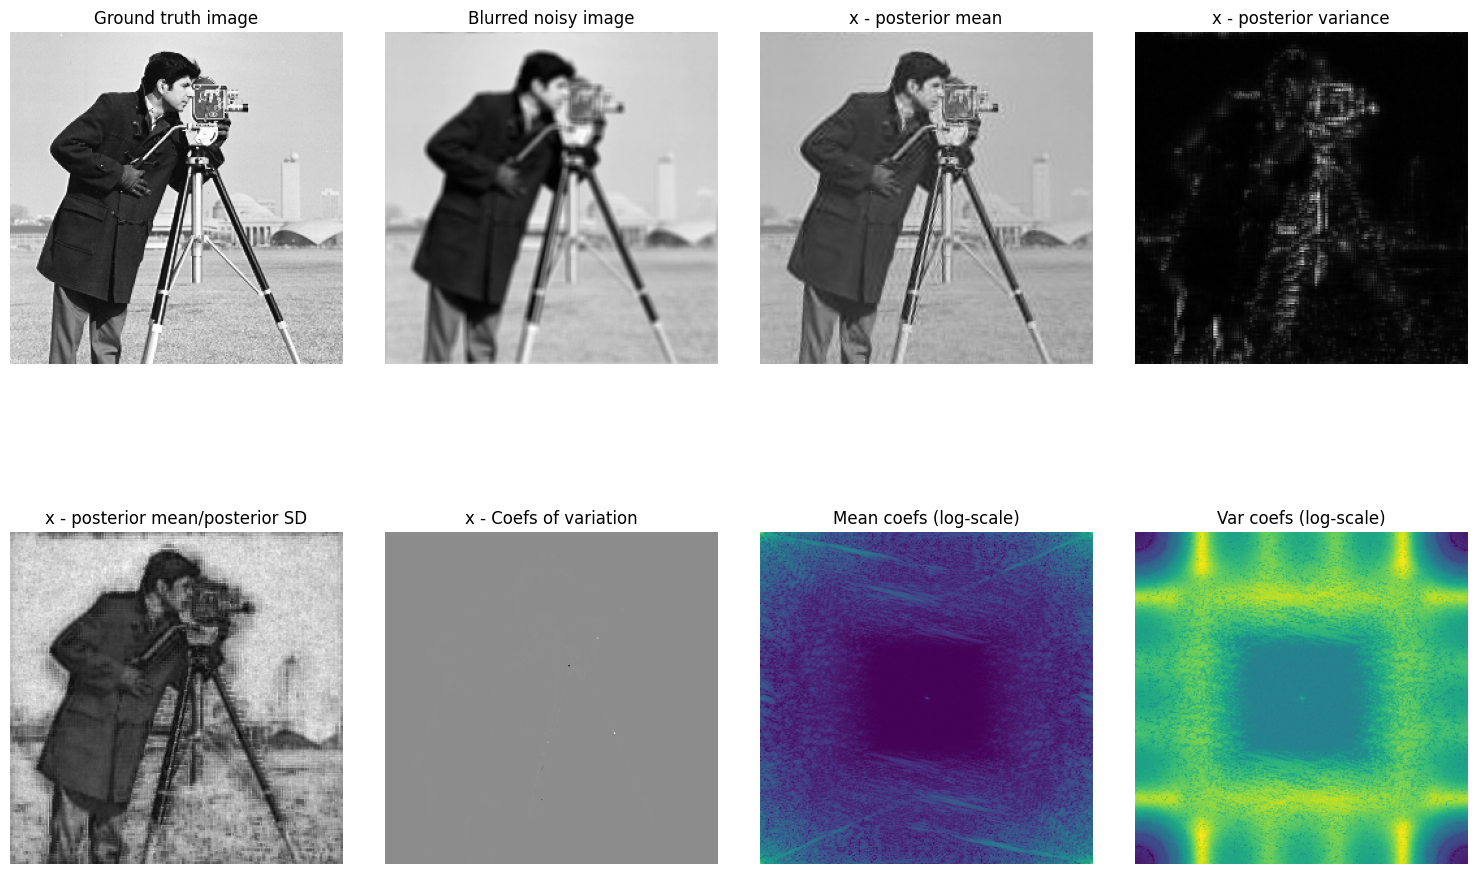

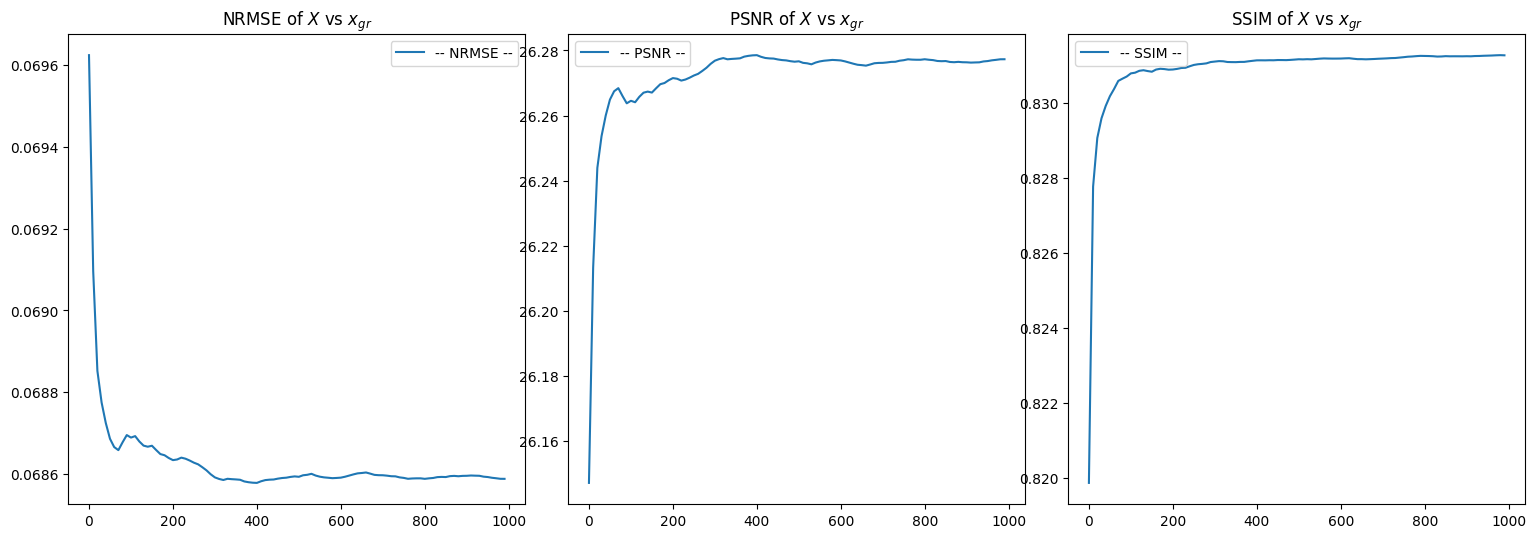

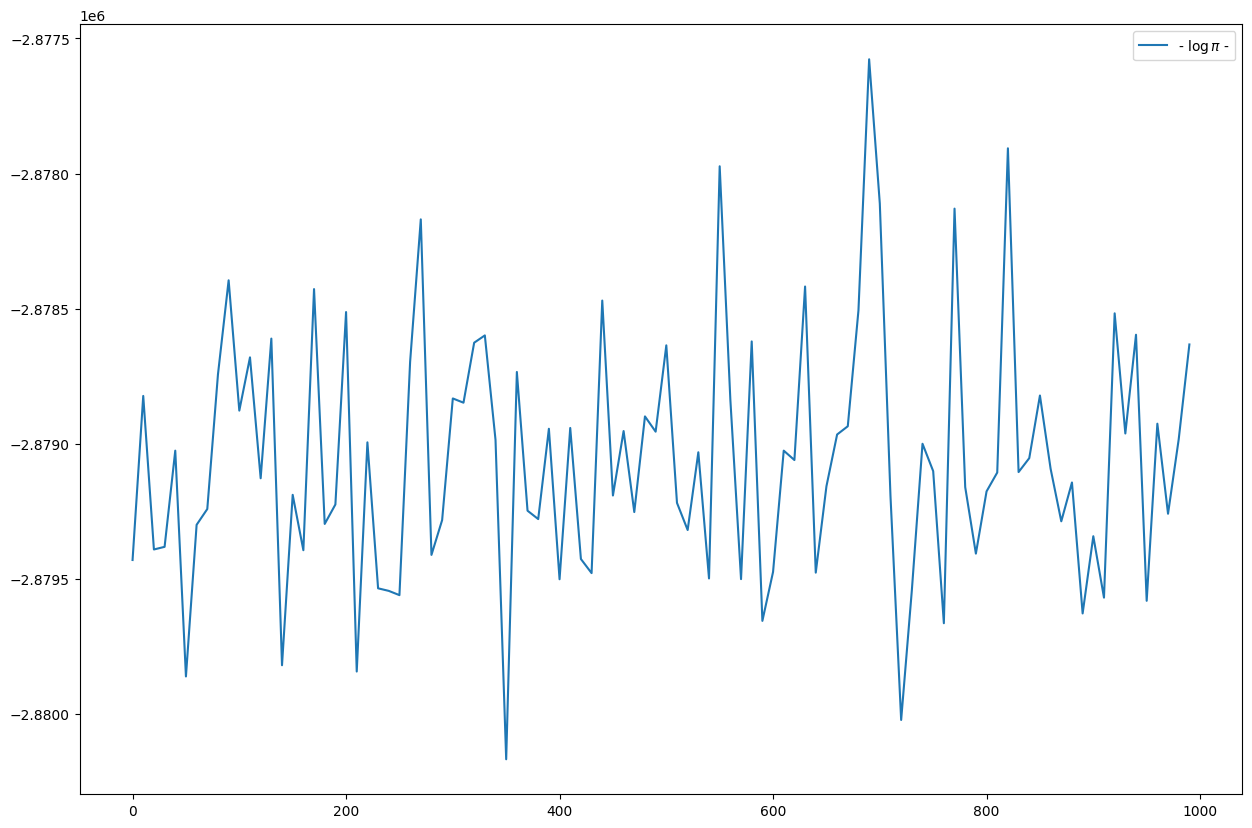

In [22]:
plots(x, y, post_meanvar, absfouriercoeff, nrmse_values, psnr_values, ssim_values, log_pi_trace)

## Autocorrelation function of the Markov chain

To analyse the convergence properties of the Markov chain generated with `SKROCK`, we display below the autocorrelation function of the slowest, median and fastest component of the resulting chain. We obtained the slowest component by computing the pixel index resulting in the smallest variance, and extracting a trace from the Markov chain for this pixel. Similarly, the median and fastest pixels are obtained by extracting traces from the Markov chain with the median and largest variance respectively. From where the autocorrelation drops to zero, we can see how many samples we need to generate another independent sample. Therefore we would like to see fast decay.

In addition, in the legend we give information about the effective sample size (ESS). This is also an important quantity that tells us about the quality of the chain. This number gives an indication how many independent samples are generated by the present Markov chain, and a higher number is better.

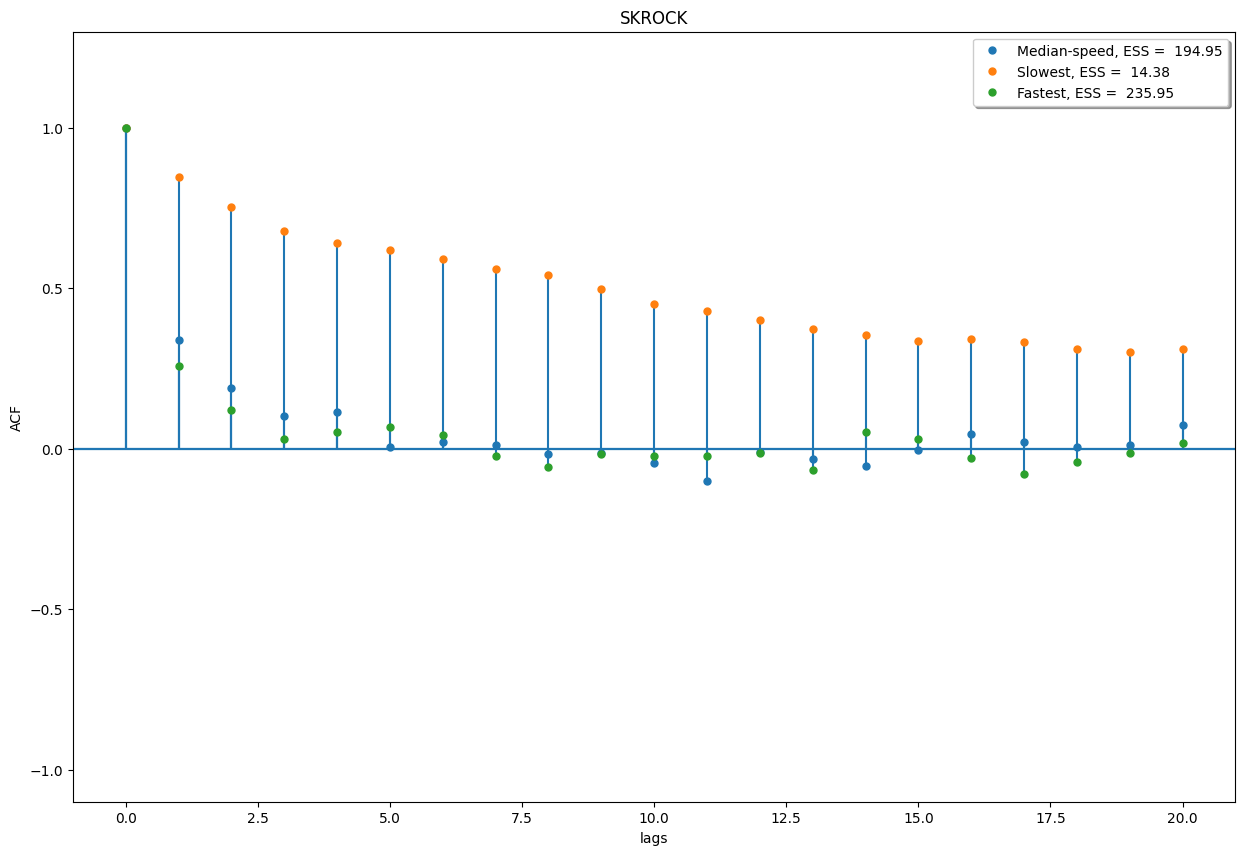

In [23]:
autocor_plots(MC_X, "SKROCK", nLags=20)

## Uncertainty quantification
We would like to use the Markov chain to visualize the variance at different scales, giving us an indication how sure the algorithm is about the solution superpixels. Dark means lower variance and depict areas where the algorithm is sure about the solution, bright areas indicate high variance.

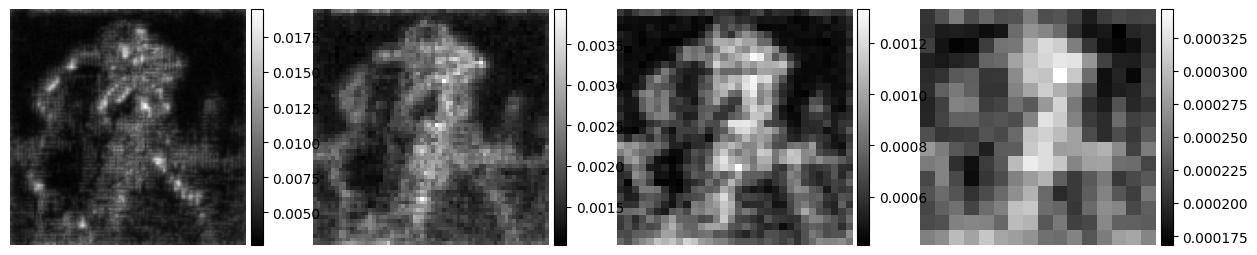

In [24]:
MC_X_array = np.array(MC_X)
shape_x = x.cpu().numpy().shape
downsampling_variance(MC_X_array.reshape(MC_X_array.shape[0], shape_x[0], shape_x[1]))
